In [13]:
# 필요한 패키지를 설치한다.
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
df = pd.read_csv("walmart_cleaned.csv")
df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    421570 non-null  int64  
 1   Store         421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   IsHoliday     421570 non-null  int64  
 4   Dept          421570 non-null  float64
 5   Weekly_Sales  421570 non-null  float64
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Type          421570 non-null  int64  
 16  Size          421570 non-null  int64  
dtypes: float64(11), int64(5), object(1)
memory usage

In [16]:
# date 컬럼을 datetime 형식으로 변환한다.
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
# 잘 바뀌었는지 확인한다.
# Dtype이 datetime64[ns]로 바뀌었음을 확인할 수 있다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    421570 non-null  int64         
 1   Store         421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   IsHoliday     421570 non-null  int64         
 4   Dept          421570 non-null  float64       
 5   Weekly_Sales  421570 non-null  float64       
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  Type          421

In [18]:
# 시계열 데이터를 정리한다.
df = df.sort_values(by='Date')

In [19]:
# 연도 컬럼을 생성한다.
df['Year'] = df['Date'].dt.year

In [20]:
## 집계 컬럼 함수 설정

def func(df):
    df_sum = {}
    # 주간 매출 합계 계산
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    # 평균 온도 계산
    df_sum['Temperature'] = df['Temperature'].mean()
    # 평균 연료 가격 계산
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    # 평균 소비자 물가 지수(CPI) 계산
    df_sum['CPI'] = df['CPI'].mean()
    # 평균 실업률 계산
    df_sum['Unemployment'] = df['Unemployment'].mean()
    # 공휴일 여부 계산 (최대값, 공휴일이 하나라도 포함되어 있으면 1로 설정)
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    return pd.Series(df_sum, index=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday'])

In [21]:
df_agg = df.groupby(['Year', 'Date']).apply(func).reset_index()

In [22]:
df_agg

,Year,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,2010,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,0.0
1,2010,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,1.0
2,2010,2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,0.0
3,2010,2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,0.0
4,2010,2010-03-05,46871470.30,42.373998,2.731816,167.727351,8.572689,0.0
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,175.919639,7.225855,0.0
139,2012,2012-10-05,47566639.31,65.456811,3.848435,175.998254,6.942141,0.0
140,2012,2012-10-12,46128514.25,57.687284,3.897425,176.123786,6.952682,0.0
141,2012,2012-10-19,45122410.57,60.152756,3.878413,176.295499,6.948928,0.0


### 매출 트렌드

Text(0.5, 1.0, '2010 ~ 2012 매출 트렌드')

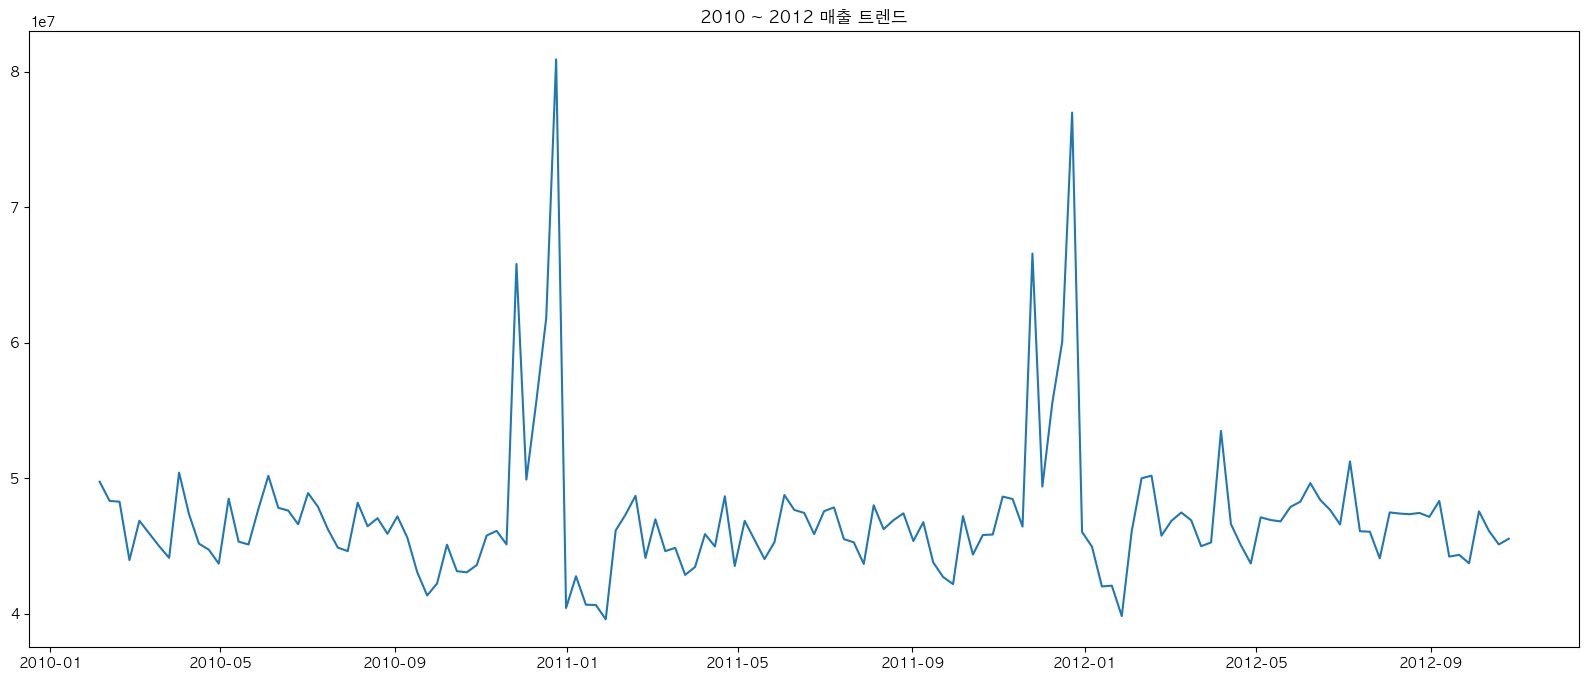

In [28]:
plt.rcParams['font.family'] = 'AppleGothic'

# 연도별 매출 트렌드
plt.figure(figsize=(20, 8))
plt.plot(df_agg.Date, df_agg.Weekly_Sales)
plt.title("2010 ~ 2012 매출 트렌드")

- 2011년 1월과 2012년 1월을 중심으로 급격한 등락폭을 보여준다.
- 이벤트나 계절성이 존재하는 것 같다.

In [31]:
# 시계열 분해
ts_decomp_Weekly_Sales = df_agg.loc[:, ['Date', 'Weekly_Sales']]
ts_decomp_Weekly_Sales.index = ts_decomp_Weekly_Sales.Date
ts_decomp_Weekly_Sales = ts_decomp_Weekly_Sales.drop('Date', axis=1)

In [33]:
# 월, 주, 일로 나눠주자.
decomp_Weekly_Sales = seasonal_decompose(ts_decomp_Weekly_Sales['Weekly_Sales'], model='additive', period=7) # 1주기로

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


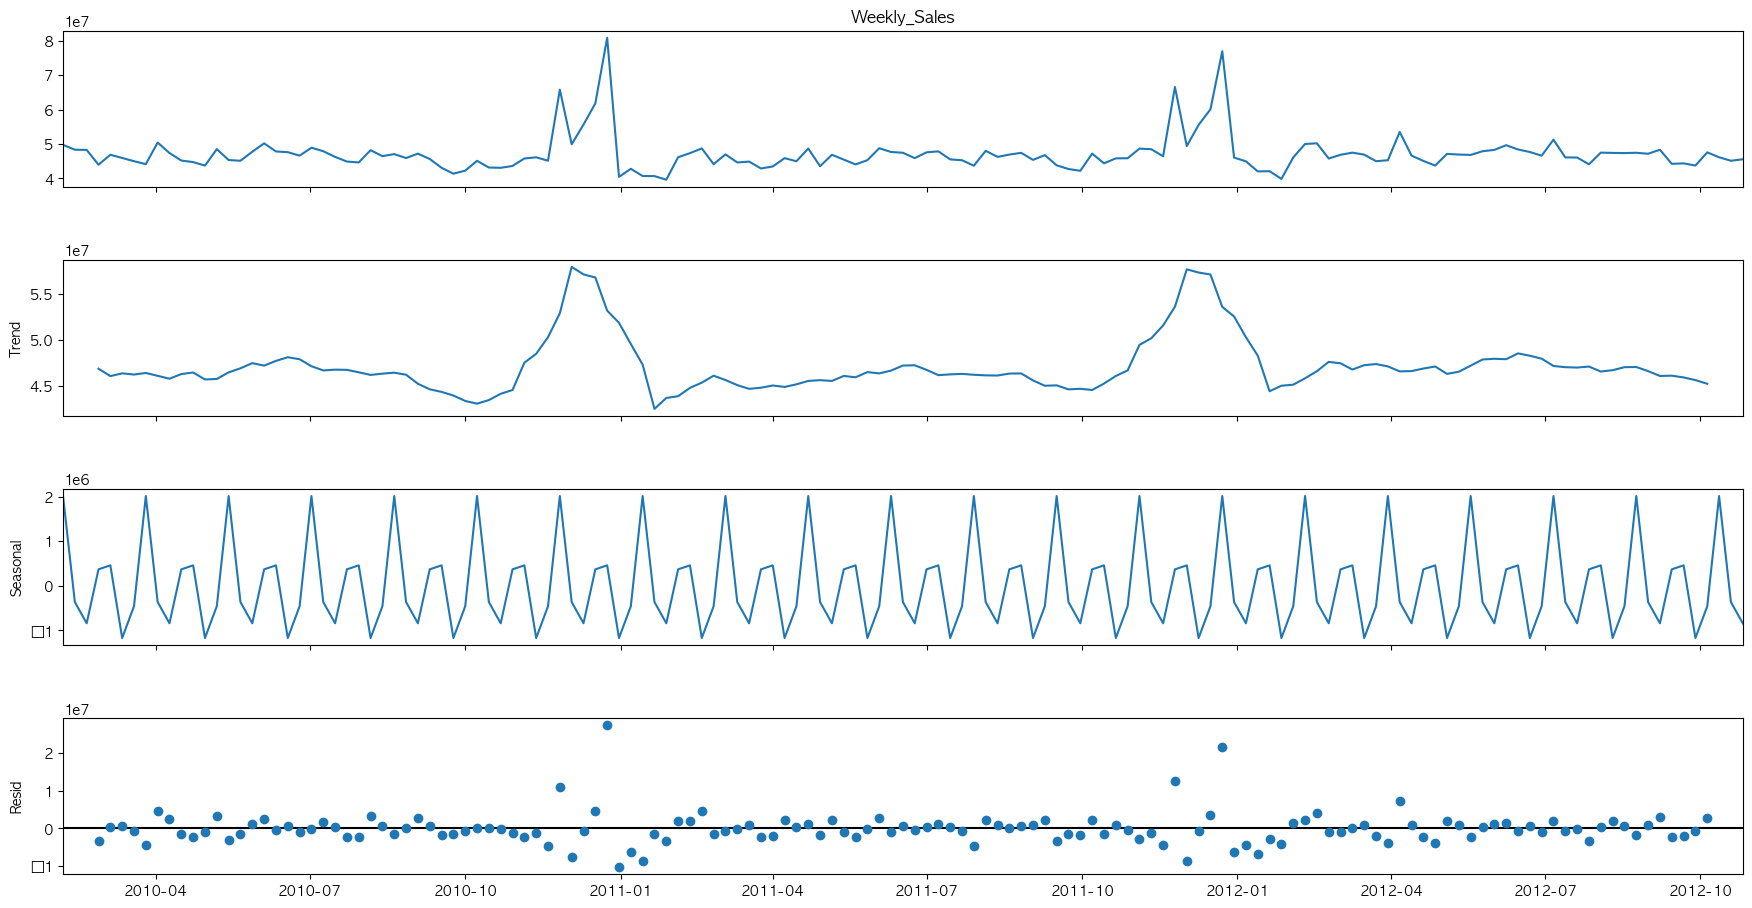

In [35]:
plt.rcParams['font.family'] = 'AppleGothic'

fig_Weekly_Sales = plt.figure()
fig_Weekly_Sales = decomp_Weekly_Sales.plot()
fig_Weekly_Sales.set_size_inches(20, 10)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


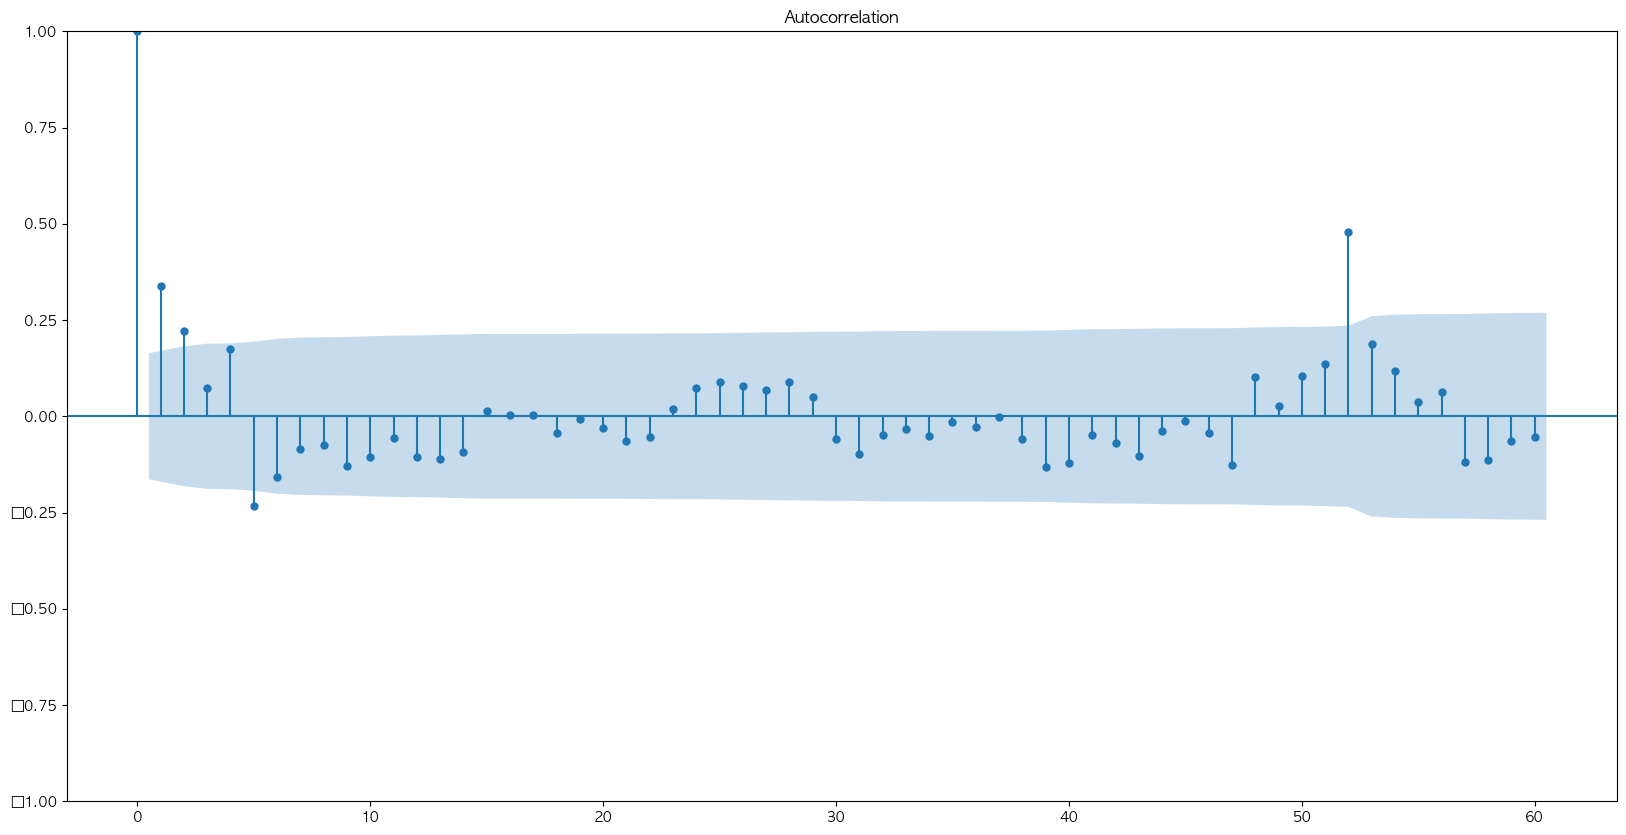

In [36]:
## ACF 그래프
fig_Weekly_Sales = plt.figure(figsize=(20, 10))
ax1_Weekly_Sales = fig_Weekly_Sales.add_subplot(111)
fig_Weekly_Sales = sm.graphics.tsa.plot_acf(ts_decomp_Weekly_Sales, lags=60, ax = ax1_Weekly_Sales)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


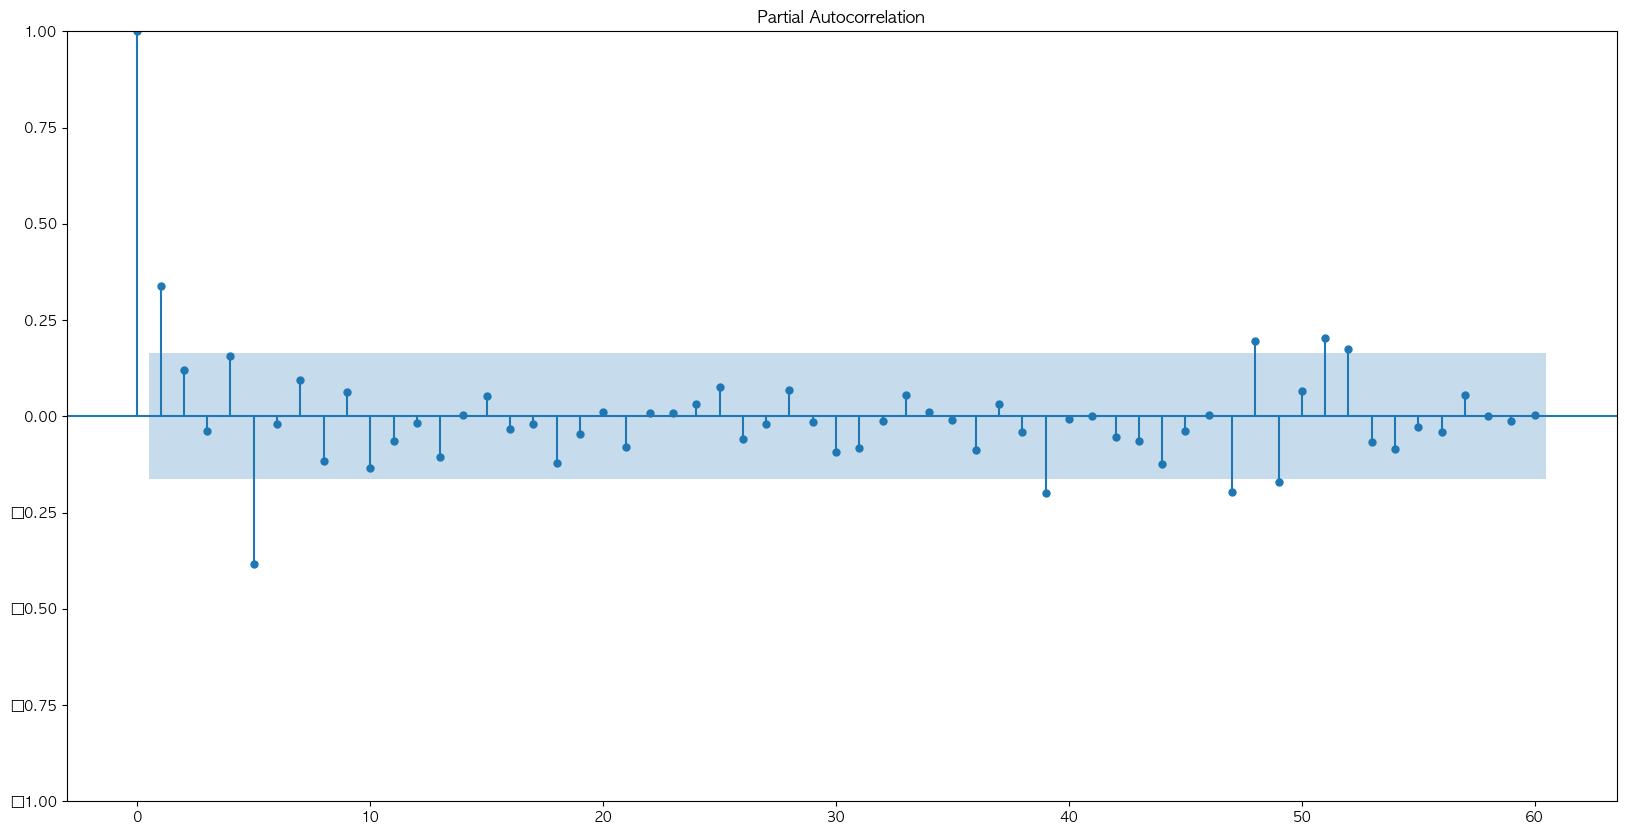

In [37]:
## PACF 그래프
fig_Weekly_Sales = plt.figure(figsize=(20, 10))
ax1_Weekly_Sales = fig_Weekly_Sales.add_subplot(111)
fig_Weekly_Sales = sm.graphics.tsa.plot_pacf(ts_decomp_Weekly_Sales, lags=60, ax = ax1_Weekly_Sales)

### CPI

Text(0.5, 1.0, '2010 ~ 2012 CPI')

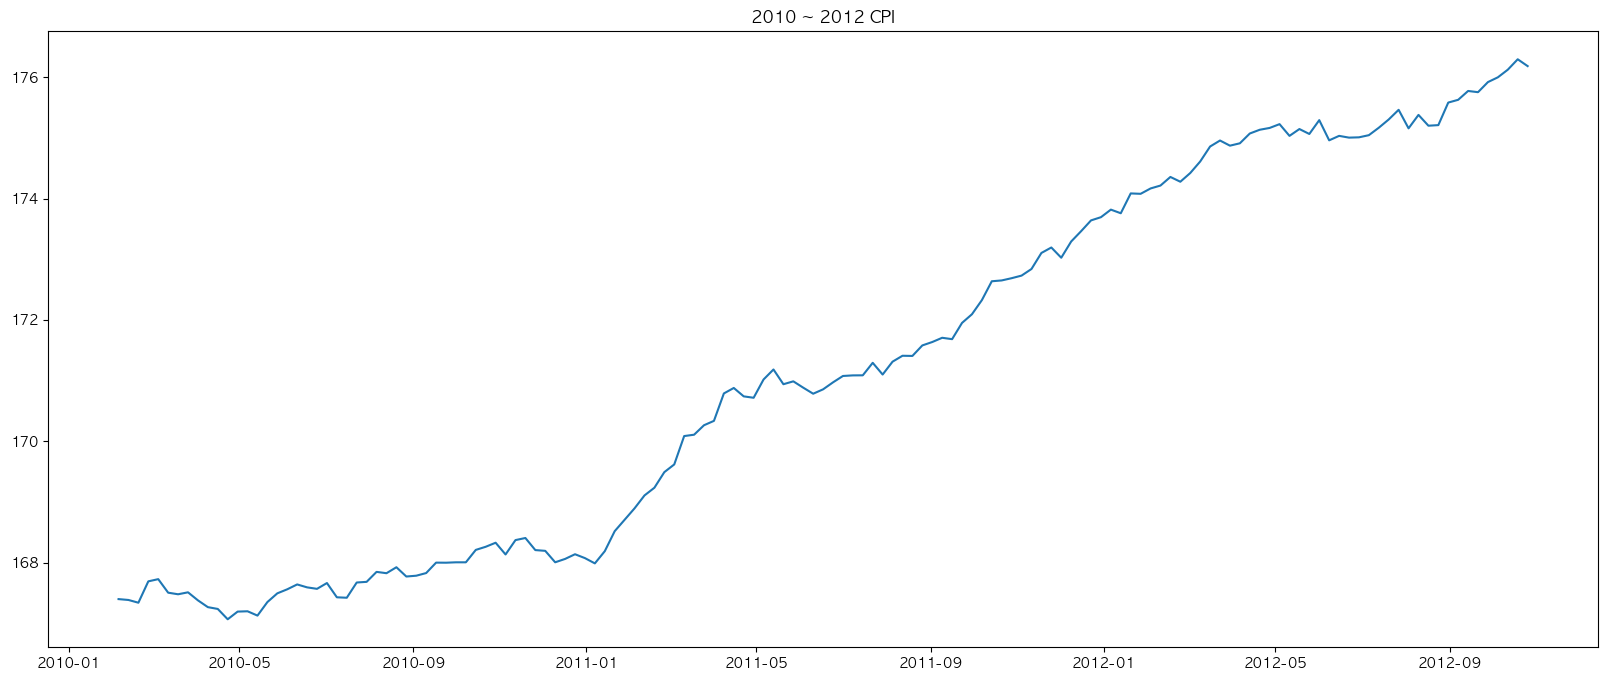

In [29]:
plt.rcParams['font.family'] = 'AppleGothic'

# 연도별 CPI 등락 확인
plt.figure(figsize=(20, 8))
plt.plot(df_agg.Date, df_agg.CPI)
plt.title("2010 ~ 2012 CPI")

In [38]:
# 시계열 분해
ts_decomp_CPI = df_agg.loc[:, ['Date', 'CPI']]
ts_decomp_CPI.index = ts_decomp_CPI.Date
ts_decomp_CPI = ts_decomp_CPI.drop('Date', axis=1)

In [39]:
# 월, 주, 일로 나눠주자.
decomp_CPI = seasonal_decompose(ts_decomp_CPI['CPI'], model='additive', period=7) # 1주기로

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


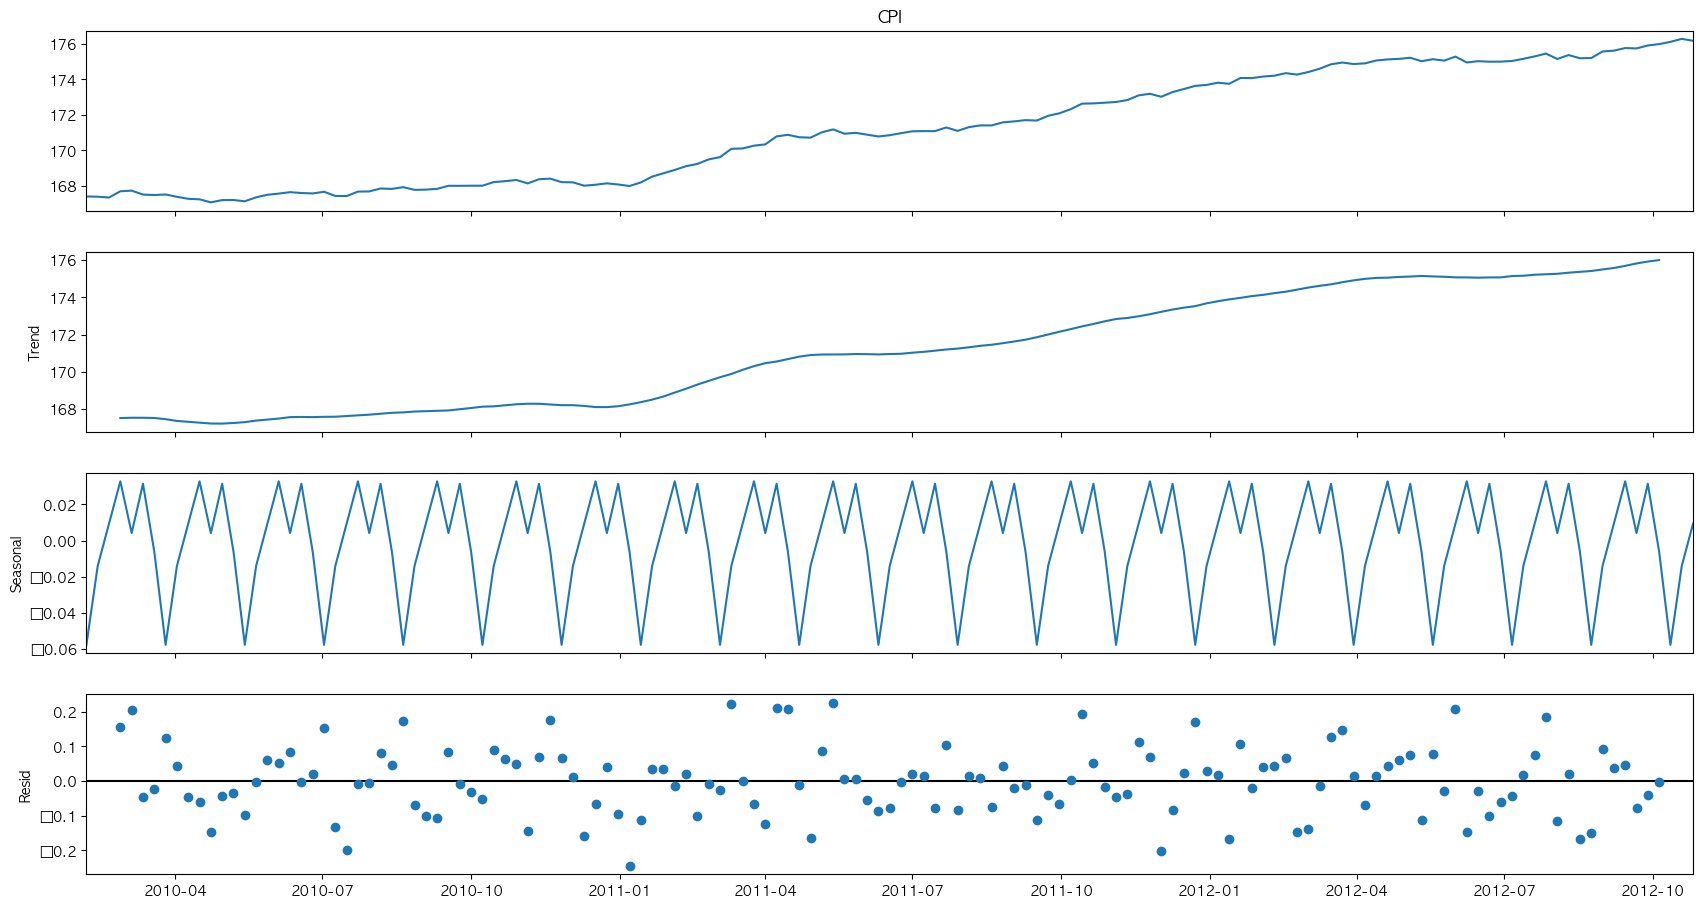

In [40]:
plt.rcParams['font.family'] = 'AppleGothic'

fig_CPI = plt.figure()
fig_CPI = decomp_CPI.plot()
fig_CPI.set_size_inches(20, 10)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


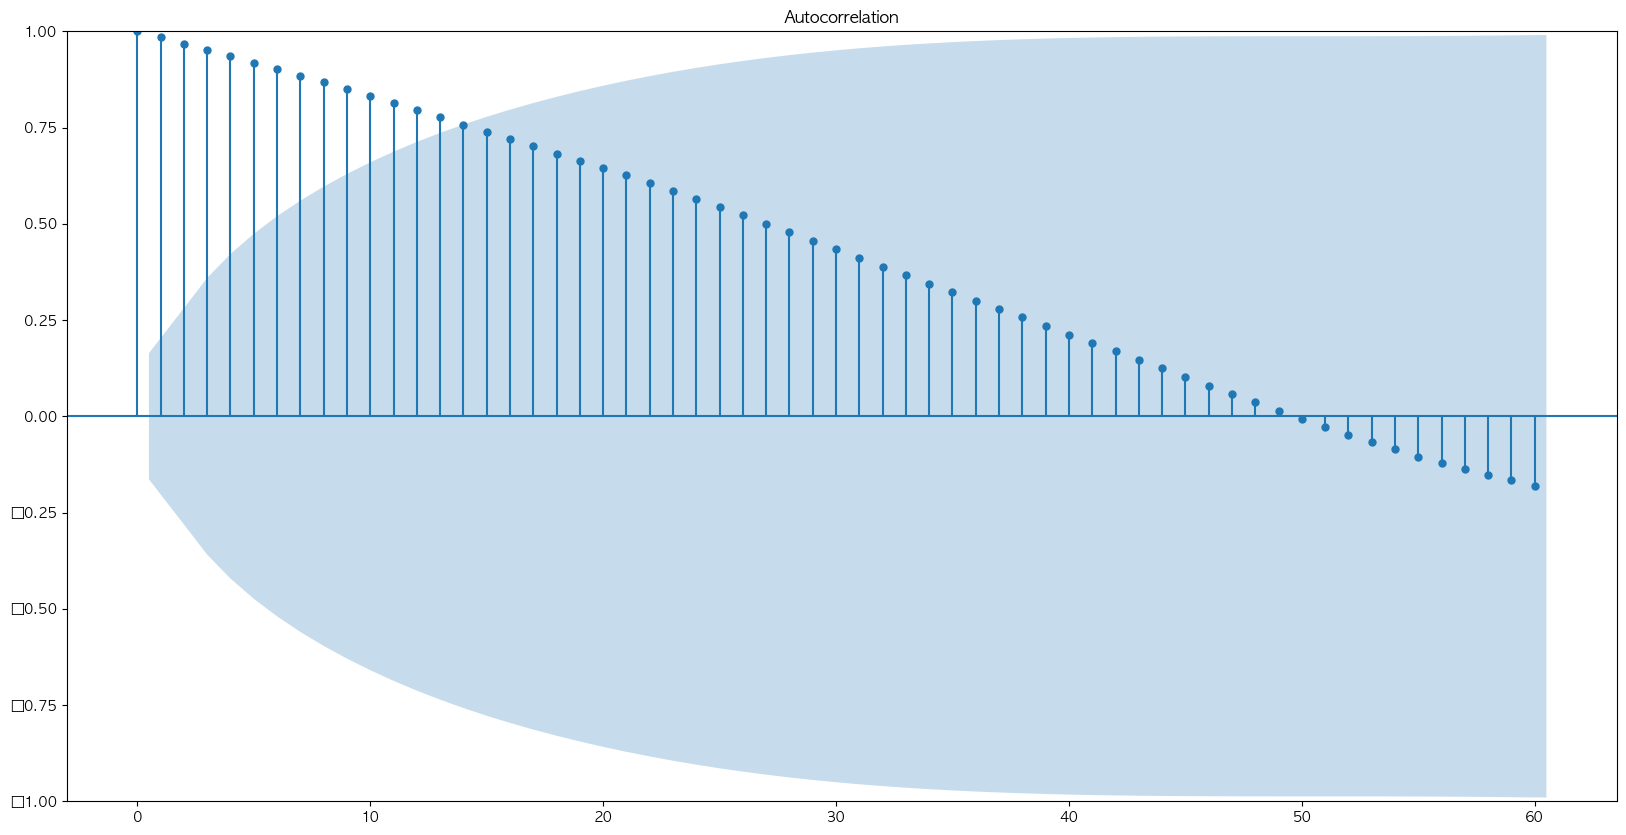

In [41]:
## ACF 그래프
fig_CPI = plt.figure(figsize=(20, 10))
ax1_CPI = fig_CPI.add_subplot(111)
fig_CPI = sm.graphics.tsa.plot_acf(ts_decomp_CPI, lags=60, ax = ax1_CPI)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


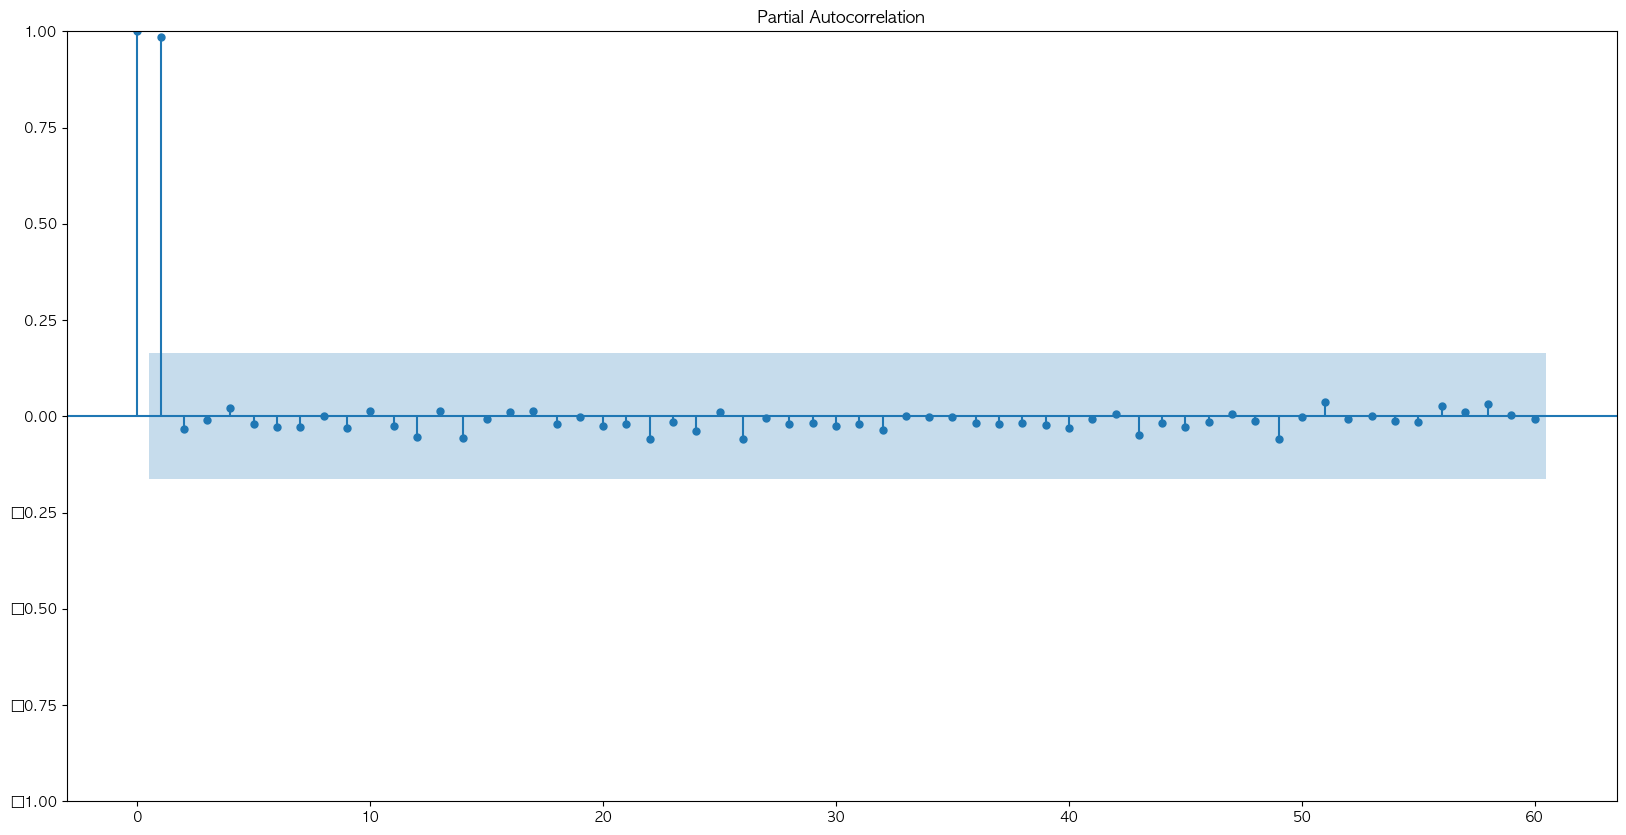

In [42]:
## PACF 그래프
fig_CPI = plt.figure(figsize=(20, 10))
ax1_CPI = fig_CPI.add_subplot(111)
fig_CPI = sm.graphics.tsa.plot_pacf(ts_decomp_CPI, lags=60, ax = ax1_CPI)

### 실업률

Text(0.5, 1.0, '2010 ~ 2012 실업률')

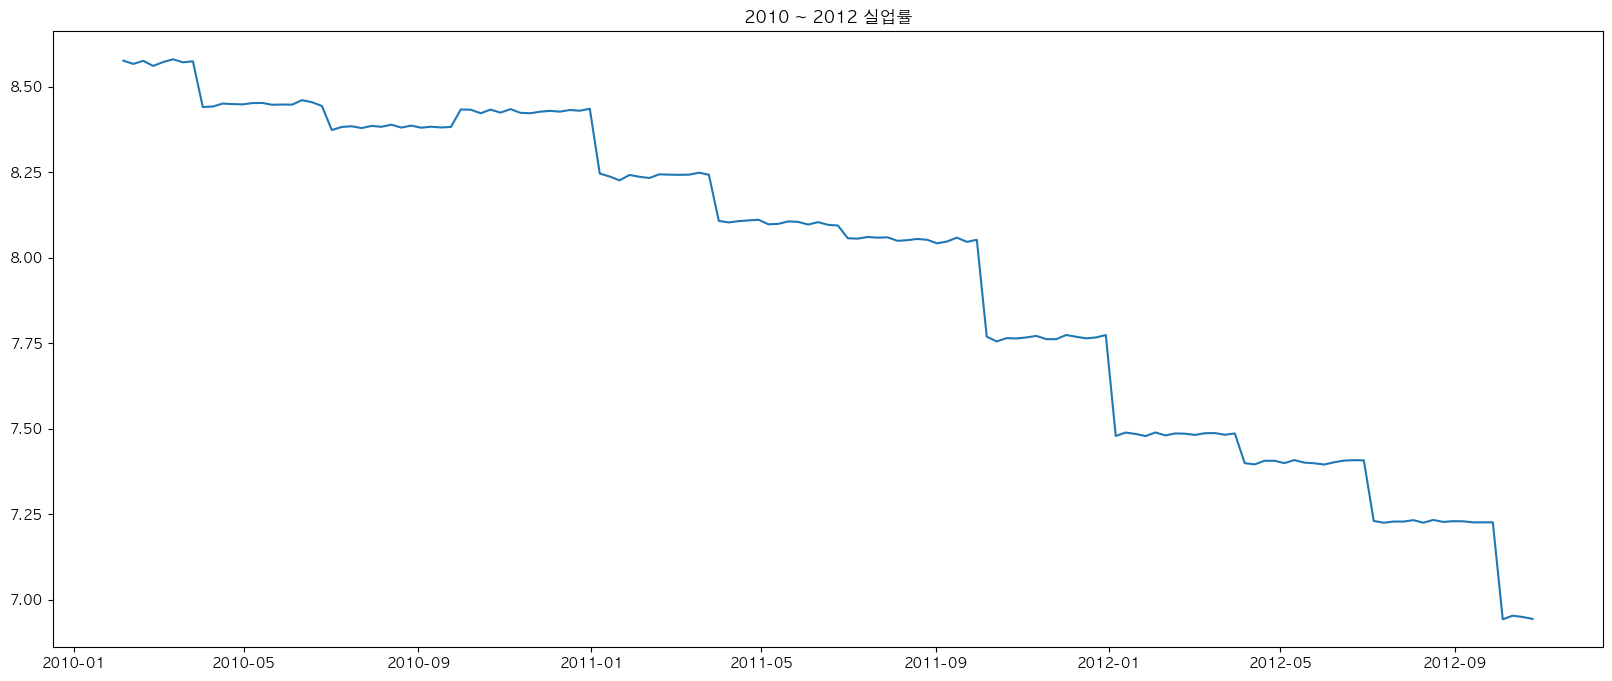

In [30]:
plt.rcParams['font.family'] = 'AppleGothic'

# 연도별 실업률 등락 확인
plt.figure(figsize=(20, 8))
plt.plot(df_agg.Date, df_agg.Unemployment)
plt.title("2010 ~ 2012 실업률")

In [43]:
# 시계열 분해
ts_decomp_Unemployment = df_agg.loc[:, ['Date', 'Unemployment']]
ts_decomp_Unemployment.index = ts_decomp_Unemployment.Date
ts_decomp_Unemployment = ts_decomp_Unemployment.drop('Date', axis=1)

In [44]:
# 월, 주, 일로 나눠주자.
decomp_Unemployment = seasonal_decompose(ts_decomp_Unemployment['Unemployment'], model='additive', period=7) # 1주기로

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


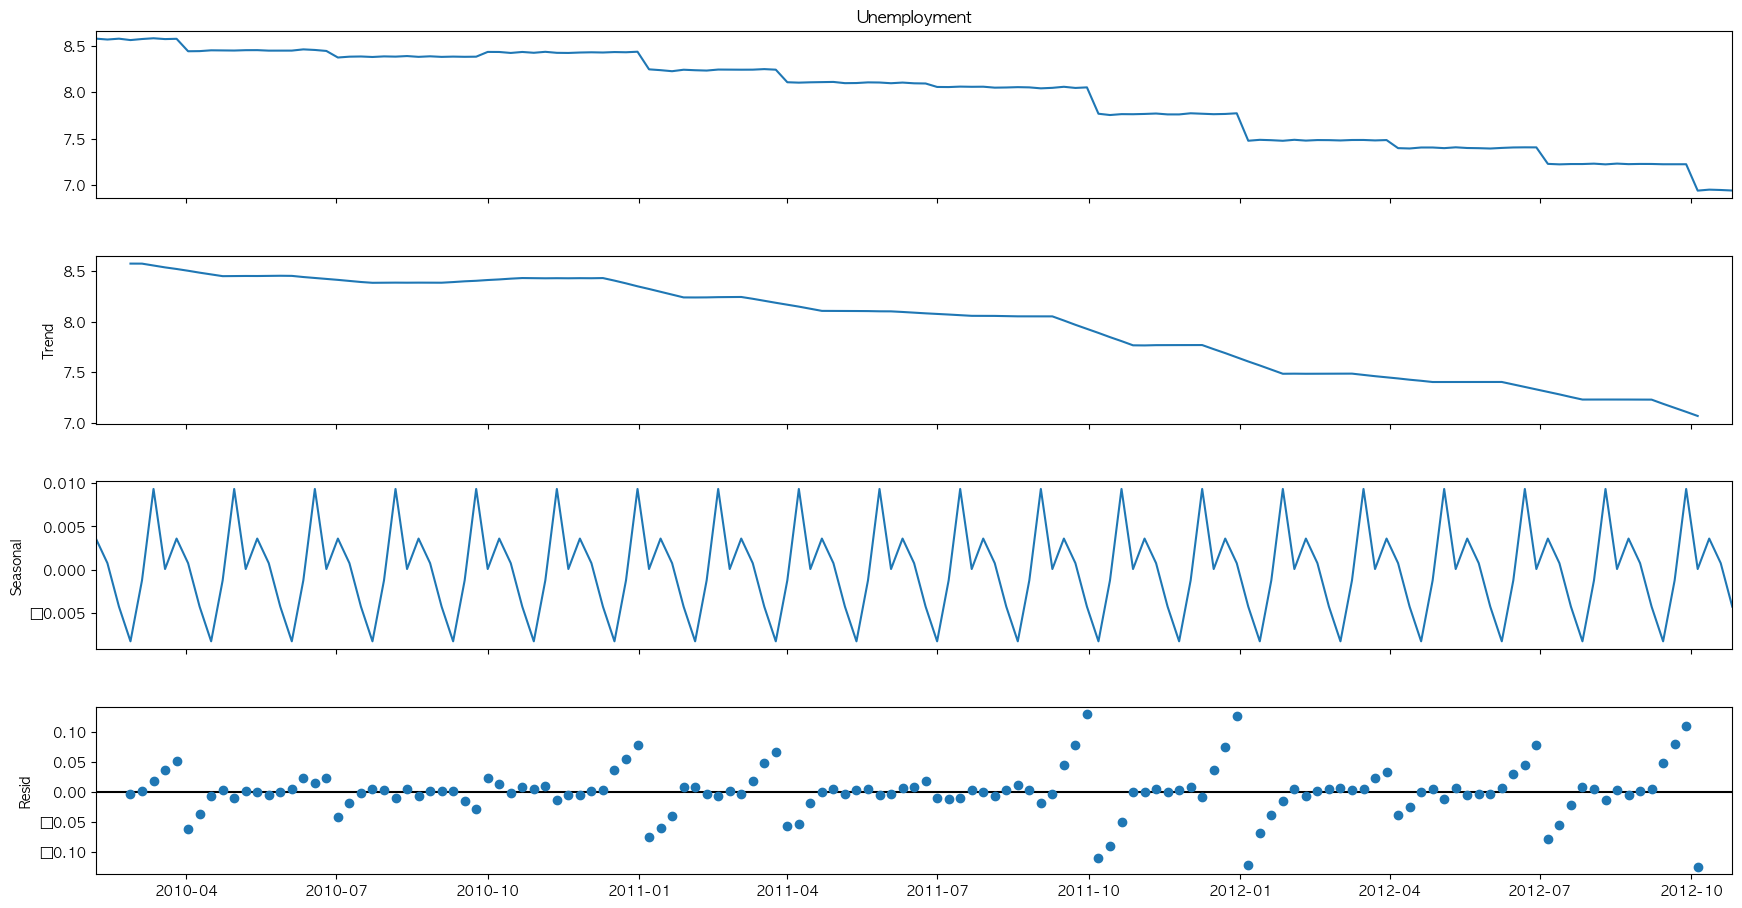

In [45]:
plt.rcParams['font.family'] = 'AppleGothic'

fig_Unemployment = plt.figure()
fig_Unemployment = decomp_Unemployment.plot()
fig_Unemployment.set_size_inches(20, 10)

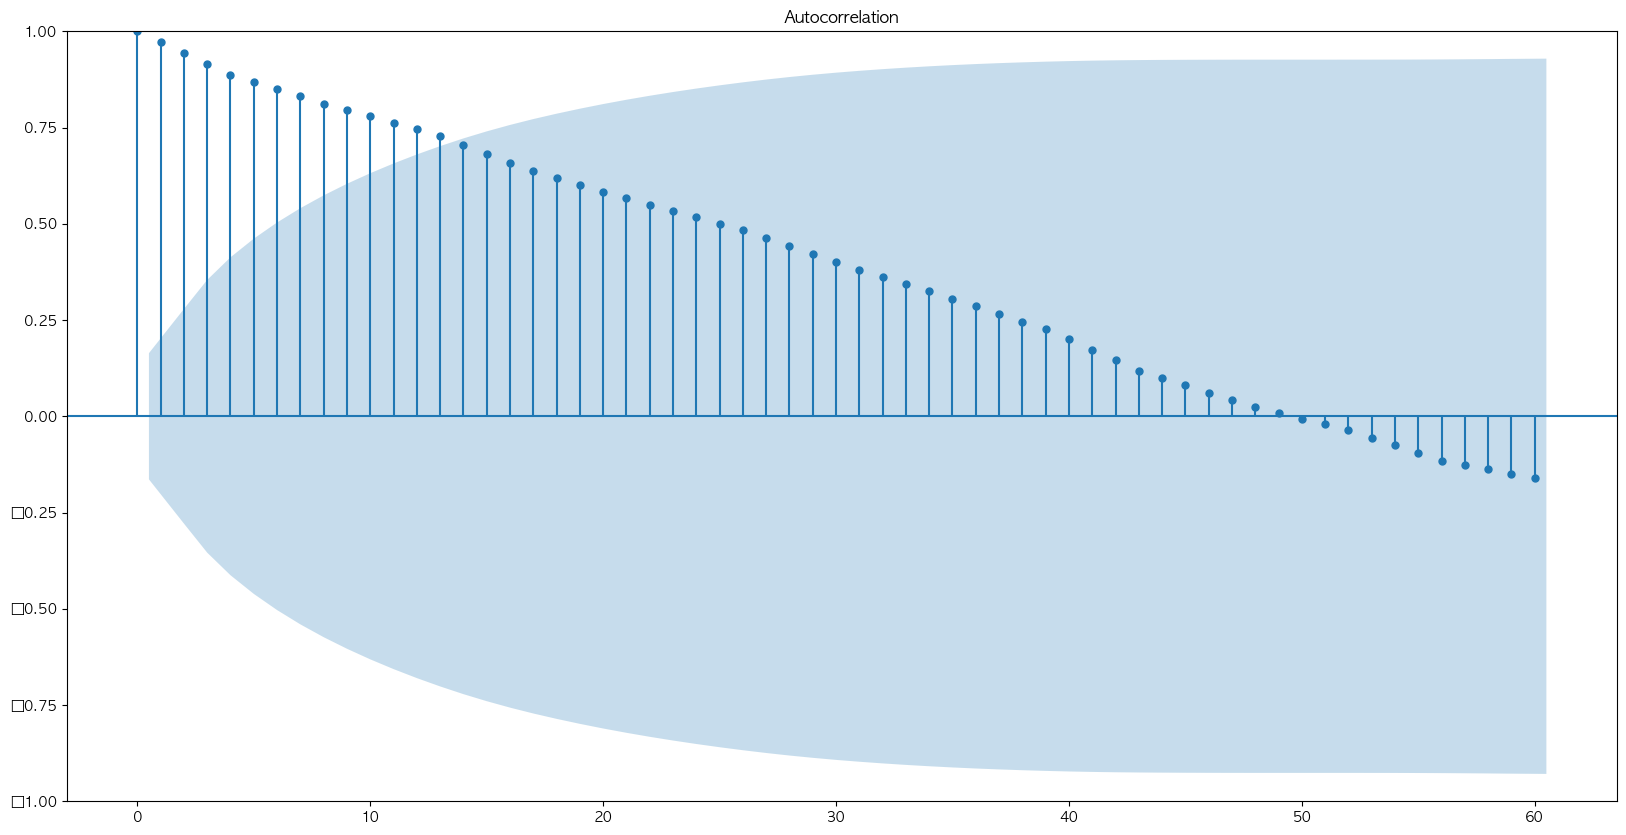

In [46]:
## ACF 그래프
fig_Unemployment = plt.figure(figsize=(20, 10))
ax1_Unemployment = fig_Unemployment.add_subplot(111)
fig_Unemployment = sm.graphics.tsa.plot_acf(ts_decomp_Unemployment, lags=60, ax = ax1_Unemployment)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


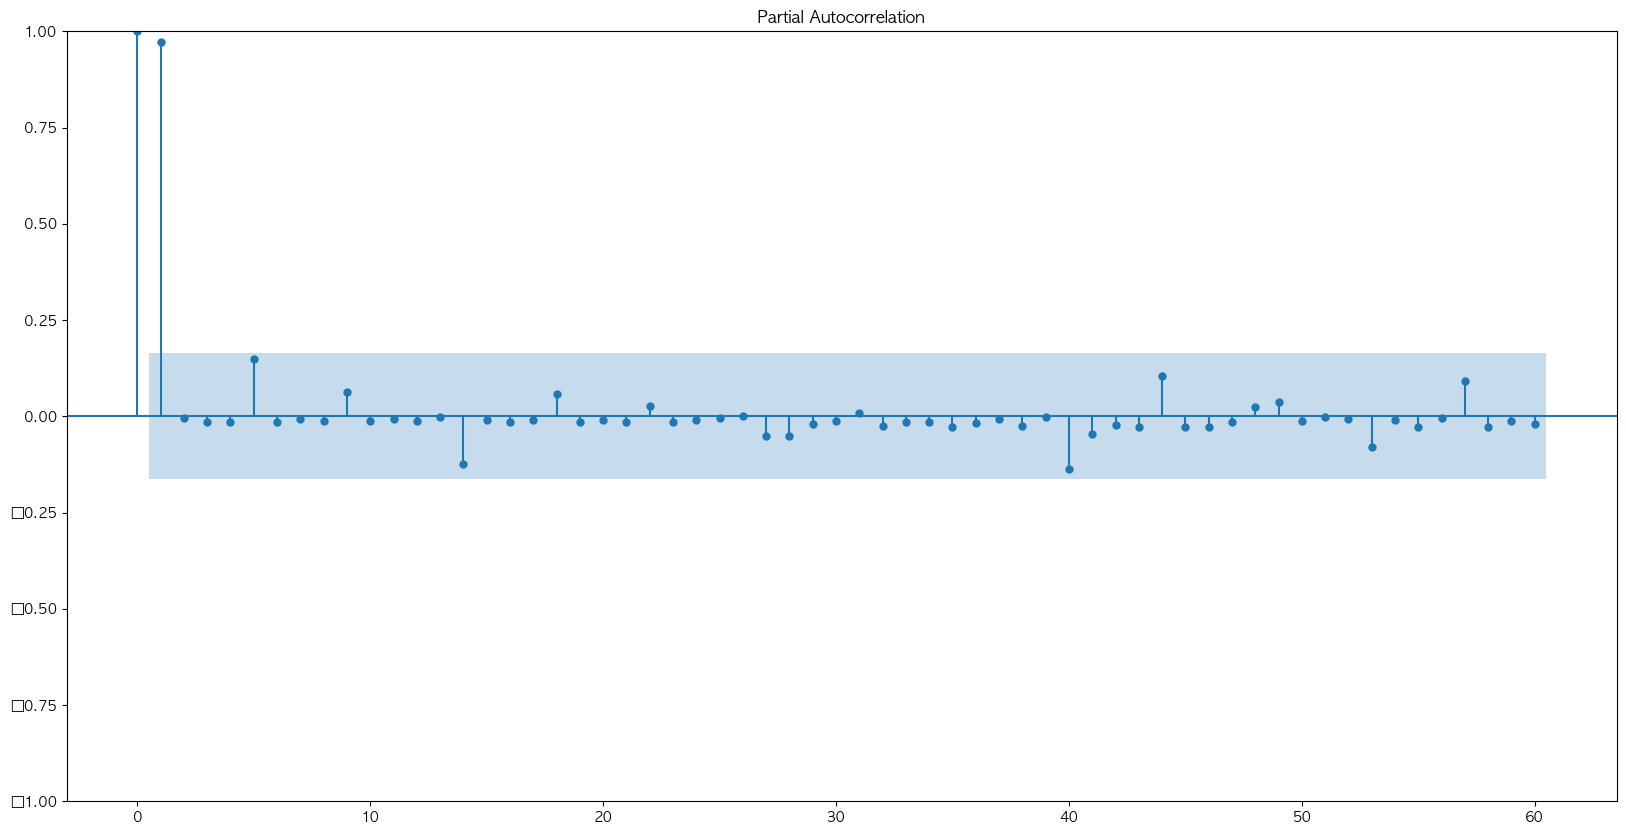

In [47]:
## PACF 그래프
fig_Unemployment = plt.figure(figsize=(20, 10))
ax1_Unemployment = fig_Unemployment.add_subplot(111)
fig_Unemployment = sm.graphics.tsa.plot_pacf(ts_decomp_Unemployment, lags=60, ax = ax1_Unemployment)